In [4]:
# Import libraries:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as pl
%matplotlib inline

- small change re. gender skews rankings
- different models? or draws from noise below
- draws of noise totally change rangkings
- discontinuity implies invidivual fairness not satisfied
- accuracy/cost slightly better with rankings
- covariate shift on the relative propensity of the genders
- ranking means you never observe most of the space
- plot error rate vs size of samples -- curve has different behaviour
- conceptually, difference between auditing and university admission -- could
- terry tao miss out at uni?
- is there some explict work here on the probability our model is wrong
- doing utility function question on the utils
- define costs for false positives and false negatives then see what happens
- over the whole cohort

# Ranking and Fair Selection


Imagine a government building an AI-driven auditing system to find people at 'high risk' of being tax cheats, and then auditing them based on that risk. This is a pretty common use case, in fact a number of government already use ML in this way to do targeted auditing of various kinds.

The approach here is to take the historical records of auditing results and use them to build a model that maps data available about the whole cohort to a risk score. There are many interesting and difficult ethical challenges here, but this blog entry wants to focus on one: once we have a risk score, how do we select who to audit?

## Ranking

A very common strategy is to select by ranking: audit the *n* individuals with the highest risk scores. What are the consequences of this approach, and are there any drawbacks?

IF your estimation of risk is accurate, then these individuals will in fact be the ones most likely to be tax cheats. So if your goal is purely to find tax cheats in a one-off audit, it's the optimal strategy. 


## Fairness

What is the effect of ranking-based selection on different demographics?





(array([  4.,  13.,  44.,  76., 184., 310., 468., 637., 710., 735., 652.,
        485., 333., 189.,  88.,  34.,  23.,   3.,   0.,   2.]),
 array([-3.43592581, -3.05572364, -2.67552146, -2.29531929, -1.91511711,
        -1.53491494, -1.15471276, -0.77451059, -0.39430841, -0.01410624,
         0.36609593,  0.74629811,  1.12650028,  1.50670246,  1.88690463,
         2.26710681,  2.64730898,  3.02751115,  3.40771333,  3.7879155 ,
         4.16811768]),
 <a list of 20 Patch objects>)

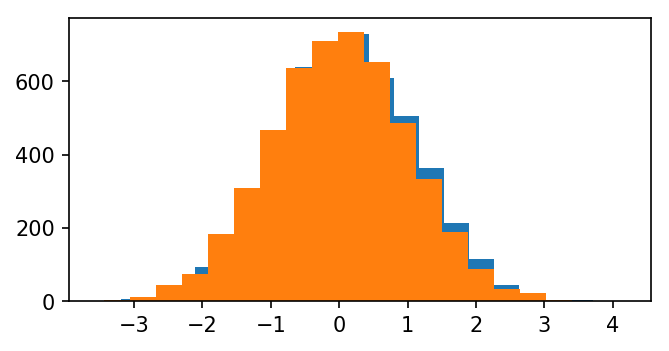

In [5]:
n = 10000 # number of unit records
frac_green = 0.5  # fraction of population that are green
def generate_data(n, delta_loc_green=0.1, delta_scale_green=0, seed=1, uniform=False, frac_green=0.5):
    loc = 0.0
    scale = 1.0
    rnd = np.random.RandomState(seed=1)
    X_isgreen = rnd.choice([0,1], size=n, p=[1 - frac_green, frac_green]).astype(bool)
    n_green = np.sum(X_isgreen)
    n_nogreen = n - n_green
    
    X1_green = rnd.normal(loc=(loc + delta_loc_green), scale=(scale + delta_scale_green), size=n_green)
    X1_nogreen = rnd.normal(loc=loc, scale=scale, size=n_nogreen)
    X1 = np.zeros(n)
    X1[X_isgreen] = X1_green
    X1[~X_isgreen] = X1_nogreen
    return np.vstack((X1, X_isgreen)).T

X_latent = generate_data(n, seed=1)
isgreen = X_latent[:, 1].astype(bool)
pl.figure(figsize=(5,2.5), dpi=150)
pl.hist(X_latent[:, 0][isgreen], bins=20)
pl.hist(X_latent[:, 0][~isgreen], bins=20)


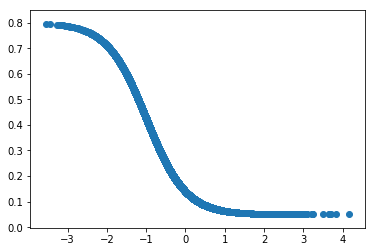

In [21]:
def logistic(x, L, k, x_0):
    r = L / (1 + np.exp( -1 * k * (x - x_0) ))
    return r

def true_prob(X):
    L = 0.75
    k = 2
    x0 = -1.0
    base_rate = 0.8    
    p = base_rate - logistic(X[:,0], L, k, x0)
    return p
    
P = true_prob(X_latent)

pl.figure()
pl.scatter(X_latent[:, 0], P)
pl.show()

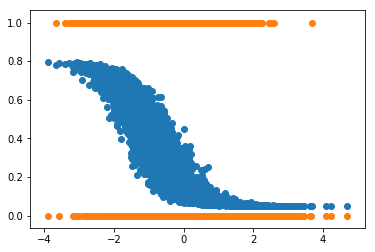

In [25]:

def sample_results(p, seed=0):
    rnd = np.random.RandomState(seed)
    results = rnd.uniform(size=p.shape) < p
    return results

# Note I'm getting the true prob here
P = true_prob(X_latent)
Y = sample_results(P)


def draw_observations(X_latent, seed=1, loc=0.0, scale=0.3):
    rnd = np.random.RandomState(seed)
    X_noise = X_latent[:, 0] + rnd.normal(loc=loc, scale=scale, size=X_latent.shape[0])
    return np.vstack((X_noise, X_latent[:,1])).T

X = draw_observations(X_latent)

pl.figure()
pl.scatter(X[:, 0], P)
pl.scatter(X[:, 0], Y)
pl.show()


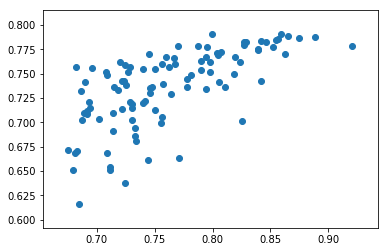

Accuracy: 0.71
Frac green selected: 0.42
Frac green guilty: 0.501


In [35]:
n_select = 100

def train_test(X, Y, P):
    X_train = X[:n//2]
    X_test = X[n//2:]
    Y_train = Y[:n//2]
    Y_test = Y[n//2:]
    P_train = Y[n//2:]
    P_test = Y[:n//2]
    return X_train, X_test, Y_train, Y_test, P_train, P_test

def estimate(X_train, Y_train, X_test):
    model = LogisticRegression(solver='lbfgs')
    # model = LogisticRegression(class_weight='balanced', solver='lbfgs')
    # model = SVC(probability=True, kernel='poly')
    model.fit(X_train, Y_train)
    p_est = model.predict_proba(X_test)[:, 1]    
    return p_est


def rank(p, Y_test, P_test):
    rank = np.argsort(p)[::-1]
    p_rank = p[rank][0:n_select]
    p_true = P_test[rank][0:n_select]
    y_true = Y_test[rank][0:n_select]
    return p_rank, p_true, y_true


# rank and select the top


pl.figure()
pl.scatter(p_rank, p_true)
pl.show()

p_rank, p_true, y_true = estimate_and_rank(X, Y)

def stats(p_rank, p_true, y_true):
    acc = np.sum(y_true) / y_true.shape[0]
    frac_green = np.sum(X[:,1][rank][0:n_select]) / n_select
    return acc, frac_green
    
    
print("Accuracy: {}".format(acc))
print("Frac green selected: {}".format(frac_green))
print("Frac green guilty: {}".format(np.sum(X[:, 1]) / X.shape[0]))





In [41]:
def baserate_selection_plot():
    baserates = np.linspace(0, 1, 20)
    out = [baserate_rank(b) for b in baserates]
    acc_vector, bias_vector = zip(*out)
    return baserates, acc_vector, bias_vector
        
def baserate_rank(b):
    Xl = generate_data(n, delta_loc_green=b)
    P = true_prob(Xl)
    Y = sample_results(P)
    X = draw_observations(Xl)
    X, Xs, Y, Ys, P, Ps = train_test(X, Y, P)
    Pe = estimate(X, Y, Xs)
    Pe_rank, P_rank, Y_rank = rank(Pe, Ys, Ps)
    stats(Pe_rank, P_rank, Y_rank)
    return acc, frac_green
        

acc_vector, bias_vector = baserate_selection_plot()
pl.figure()
pl.plot(baserates, bias_vector)
pl.plot(baserates, acc_vector)
pl.show()
    

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices